### High Energy Physics, Particle tracking in CERN detectors 

<b>What is happening? </b>
To explore what our universe is made of, scientists at CERN are colliding protons, essentially recreating mini big bangs,
and meticulously observing these collisions with intricate silicon detectors.
While orchestrating the collisions and observations is already a massive scientific accomplishment,
analyzing the enormous amounts of data produced from the experiments is becoming an overwhelming challenge. 

Every particle leaves a track behind, like a car leaving tire marks. The particle is not caught in action.
Now we want to link every track to one hit that the particle created. In every event, a large number of particles are released.
They move along a path leaving behind their tracks. They eventually hit a particle detector "surface".
In this Notebook I am going to visualize these tracks in the best way possible and will also go through some more details.


<ul>
    <li><a href="#import">Importing libraries</a></li>
    <li><a href="#extractData">Extract data</a></li>
    <li><a href="#clean">Cleaning steps</a></li>
    <li><a href="#detectors">Detectors</a></li>
    <li><a href="#particles">Particles</a></li>
    <li><a href="#trajectory">Particle trajectories</a></li>
    <li><a href="#DBSCAN">DBSCAN, (eps, MinPts and final score)</a></li>
</ul>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<a id='import'></a>"))
display(HTML("<style>.container { width:100% !important;}</style>"))

display(HTML("<h2>Importing libraries</h2>"))

In [2]:
###IMPORTING THE LIBRARIES 
import os
# linear algebra
import numpy as np
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from bokeh.palettes import Cividis


# Trackml library to help dealing with data
import trackml # pip install --user git+https://github.com/LAL/trackml-library.git
from trackml.dataset import load_event
from trackml.score import score_event

import ipyvolume as ipv
# pip install ipyvolume --user
# jupyter nbextension enable --py --user ipyvolume
# jupyter nbextension enable --py --user widgetsnbextension

# for clustering with DBSCAN

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
# pip install -U scikit-learn
# conda install -c intel scikit-learn

# To help read the files
from os import listdir
from os.path import isfile, join


<a id='extractData'></a>
## Extract data
Event data(hits, cells, particles, truth) and detectors

####  <a href='https://we.tl/t-H2MZL3L1WJ'> Link to download DATA </a> (Expires on Jan 21st)
####  <p> The project is also uploaded on jhub. So the data can be found there too </p> 
####  <p> Download the detectors.cvs file and the train_sample zip. Exctract the zip file and all should set. The notebook, the detectors file and the train_sample folder should be in the same folder </p> 

In [3]:
# Ekstract all filenames in train_100_events document
eventFilePath = 'train_sample/train_100_events'

event = [f.split('-')[0] for f in listdir(eventFilePath) if isfile(join(eventFilePath, f))]
event1 = ['event000001000', 'event000001004'] #Since event is a really big dataset, feel free to use the preferred one. For testing event1 is unsurprisingly faster


# Load_event function from trackml library to load hits, cells, particles, truth  
for idx, e in enumerate(event1):
    hits, cells, particles, truth = load_event(os.path.join('train_sample/train_100_events', e))
    
#for idx, event in enumerate(event_prefix):
#    hits, cells, particles, truth = load_event(os.path.join('train_sample/train_100_events', event))


# Read the detectors file
detectors = pd.read_csv('detectors.csv')

<a id='clean'></a>
### The data is already curated but just in case let's get throgh some steps to clean our data 🧹

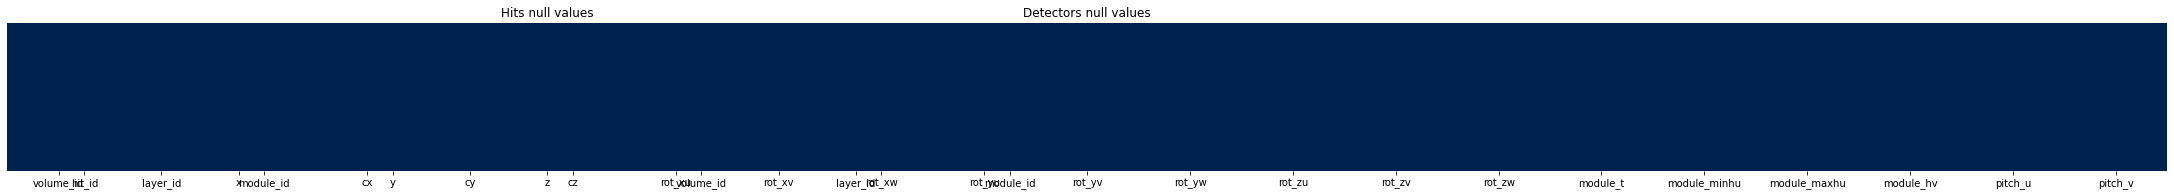

As one can see, there are no null values


Object data types sum in Detectors: 0
Object data types sum in Hits: 0
As we see there isn't any. If there was any I would use the .unique() function to detect and then try to change the data types within.


N/a values in Detectors: 0
N/a values in Hits: 0


Duplicated values in Detectors: 0
Duplicated values in Hits: 0


count    18728.000000
mean         5.398761
std          2.865323
min          2.000000
25%          4.000000
50%          4.000000
75%          8.000000
max         14.000000
Name: layer_id, dtype: float64
count    138568.000000
mean          5.902272
std           3.401814
min           2.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          14.000000
Name: layer_id, dtype: float64
count    138568.000000
mean         22.398973
std        1063.884888
min       -2955.500000
25%        -602.500000
50%          12.550050
75%         697.500000
max        2955.500000
Name: z, dtype: float64
From this point there are no visible outliers. Let's continue.


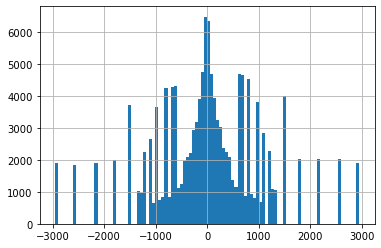

In [4]:
display(HTML("<b>1. Checking for null values. Visualizing on a heatmap for better view</b>"))
fig = plt.figure(figsize = (30,3)) # Yes some columns mix, but I left it like this to read the col names better (width 30 would be better 80 but the col names would be unreadable)

ax1 = fig.add_subplot(111) 
ax2 = fig.add_subplot(121)
# ax3 = fig.add_subplot(131)
# ax4 = fig.add_subplot(141)
# ax5 = fig.add_subplot(151)

sns.heatmap(detectors.isnull(), yticklabels = False, cbar = False, cmap = 'cividis', ax=ax1)
ax1.set_title("Detectors null values")
sns.heatmap(hits.isnull(), yticklabels = False, cbar = False, cmap = 'cividis', ax=ax2)
ax2.set_title("Hits null values")
# sns.heatmap(cells.isnull(), yticklabels = False, cbar = False, cmap = 'cividis', ax=ax3)
# sns.heatmap(particles.isnull(), yticklabels = False, cbar = False, cmap = 'cividis', ax=ax4)
# sns.heatmap(truth.isnull(), yticklabels = False, cbar = False, cmap = 'cividis', ax=ax5)
plt.tight_layout(pad=0., w_pad=0., h_pad=0.)
plt.show()
print("As one can see, there are no null values")


display(HTML("<b>2. Checking for 'object' data types, if there is any. </b>"))
# print(detectors.dtypes) It can be shown like this, but let's consider we have even more data that we can not read easily

print('Object data types sum in Detectors: %d' % (detectors.dtypes == 'object').sum())
print('Object data types sum in Hits: %d' % (hits.dtypes == 'object').sum())

print("As we see there isn't any. If there was any I would use the .unique() function to detect and then try to change the data types within.")


display(HTML("<b>3. Checking for N/A values </b>"))

print('N/a values in Detectors: %d' % (detectors.isna().any().sum()))
print('N/a values in Hits: %d' % (hits.isna().any().sum()))

display(HTML("<b>4. The same for duplicated values "))

print('Duplicated values in Detectors: %d' % (detectors.duplicated().any().sum()))
print('Duplicated values in Hits: %d' % (hits.duplicated().any().sum()))


display(HTML("<b>5. Checking for outliers "))

print(detectors.layer_id.describe())
print(hits.layer_id.describe())
print(hits.z.describe())

hits.z.hist(bins=100)

print("From this point there are no visible outliers. Let's continue.")


<a id='detectors'></a>
## Detectors

The detector is built from silicon slabs (or modules, rectangular or trapezoïdal), arranged in cylinders and disks, which measure the position (or hits) of the particles that cross them. The detector modules are organized into detector groups or volumes identified by a volume id. Inside a volume they are further grouped into layers identified by a layer id. Each layer can contain an arbitrary number of detector modules, the smallest geometrically distinct detector object, each identified by a module_id. Within each group, detector modules are of the same type have e.g. the same granularity. All simulated detector modules are so-called semiconductor sensors that are build from thin silicon sensor chips. Each module can be represented by a two-dimensional, planar, bounded sensitive surface. These sensitive surfaces are subdivided into regular grids that define the detectors cells, the smallest granularity within the detector.

In [5]:
# The columns needed
detectors[['volume_id', 'layer_id', 'module_id','module_t', 'cx', 'cy', 'cz']].head()

volume_id  layer_id  module_id  module_t        cx        cy      cz
0          7         2          1      0.15  -65.7965  -5.17830 -1502.5
1          7         2          2      0.15 -139.8510  -6.46568 -1502.0
2          7         2          3      0.15 -138.6570 -19.34190 -1498.0
3          7         2          4      0.15  -64.1764 -15.40740 -1498.0
4          7         2          5      0.15 -136.2810 -32.05310 -1502.0

In [6]:

print('Finding out the max and min of xyz so we can decide the limit in the graph')
xmin, xmax = detectors['cx'].min(), detectors['cx'].max()
ymin, ymax = detectors['cy'].min(), detectors['cy'].max()
zmin, zmax = detectors['cz'].min(), detectors['cz'].max()

print('x: %.1f  %.1f' % (xmin, xmax))
print('y: %.1f  %.1f' % (ymin, ymax))
print('z: %.1f  %.1f' % (zmin, zmax))

Finding out the max and min of xyz so we can decide the limit in the graph
x: -1021.3  1021.3
y: -1021.3  1021.3
z: -2955.5  2955.5


In [7]:
 # So we can have the 3 coordinates together
groupby = detectors.groupby(['volume_id', 'layer_id','module_t']).apply(lambda x: x[['cx', 'cy', 'cz']].values.tolist()).reset_index(name='xyz')
groupby2 = detectors.groupby(['volume_id']).apply(lambda x: x[['cx', 'cy', 'cz']].values.tolist()).reset_index(name='xyz')

<b> Let's "layer" the detector to have a clearer understanding </b>

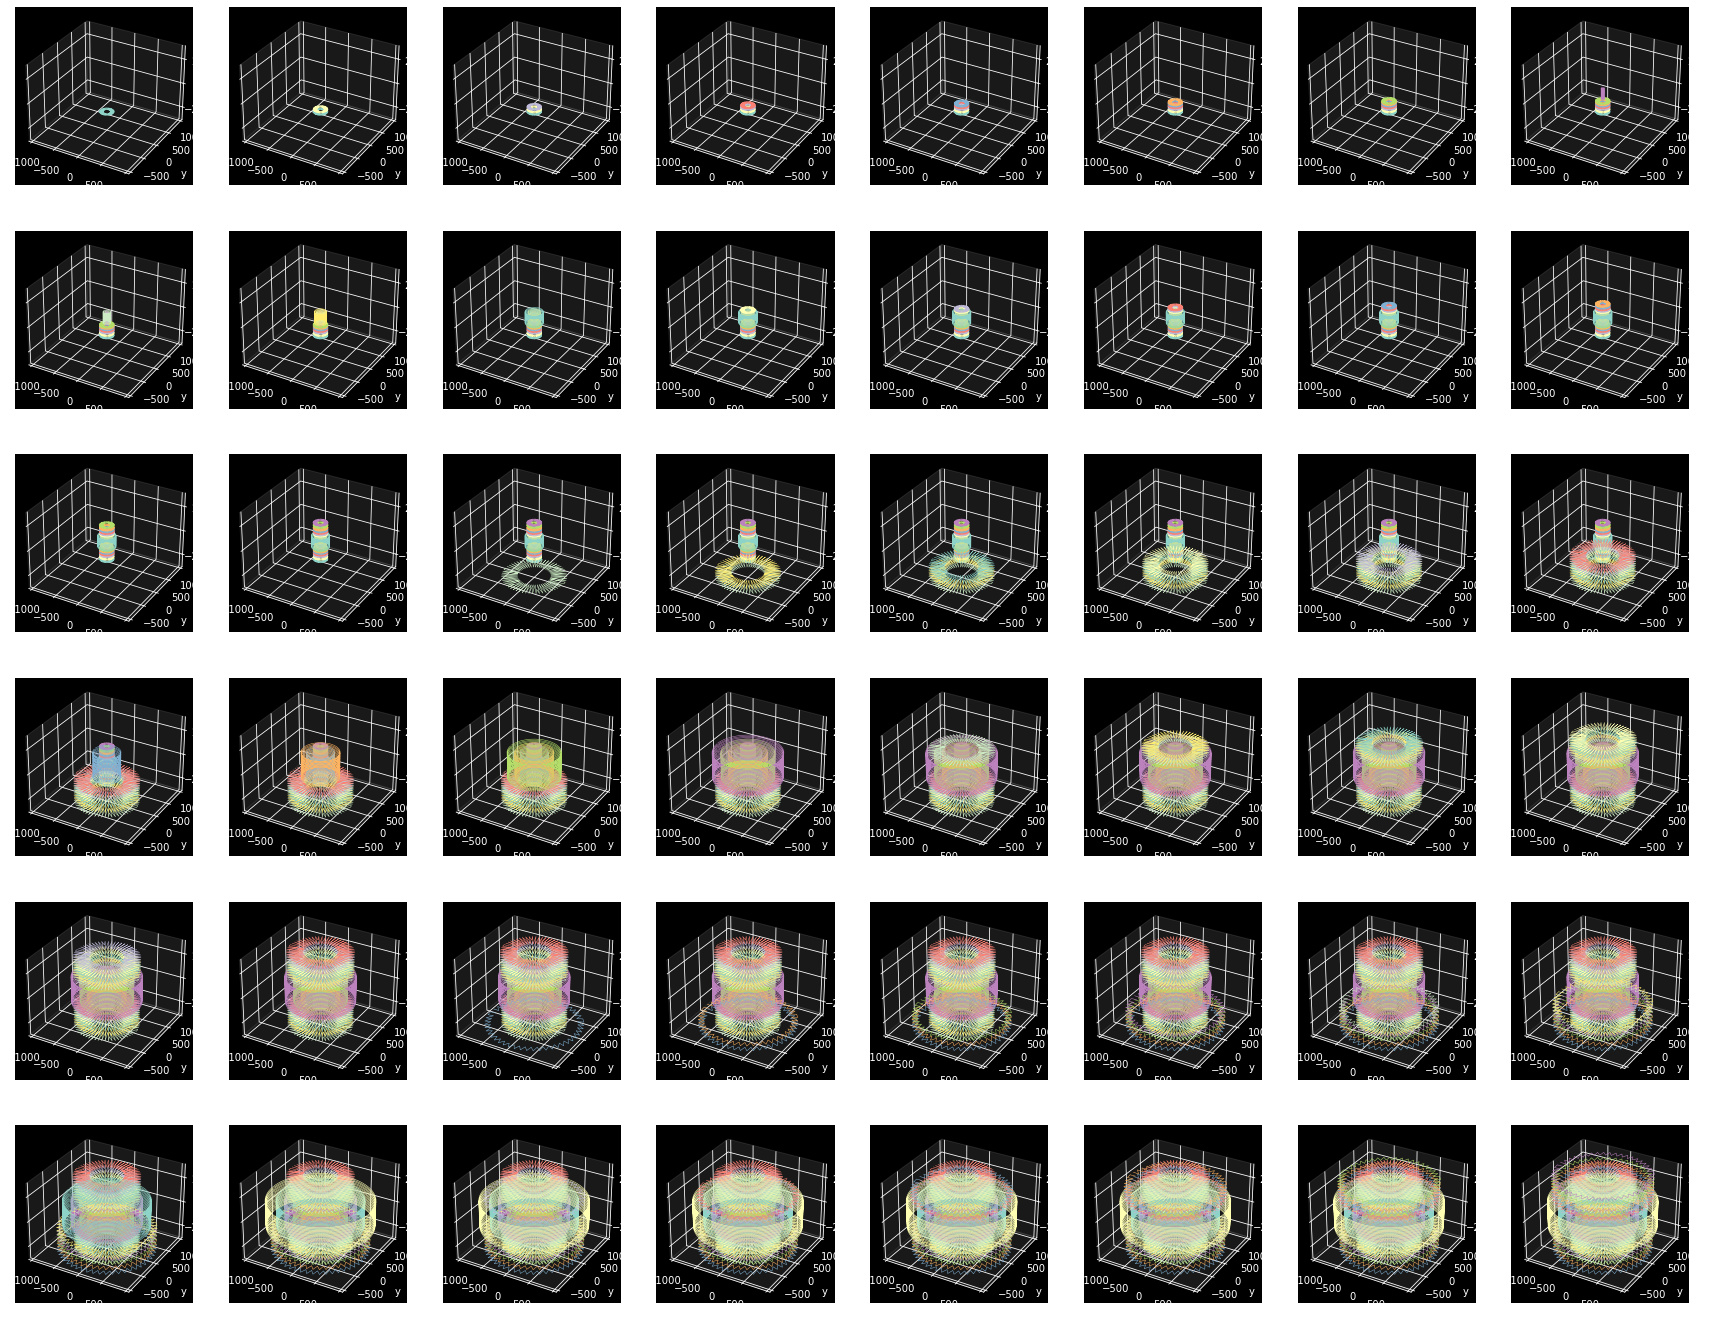

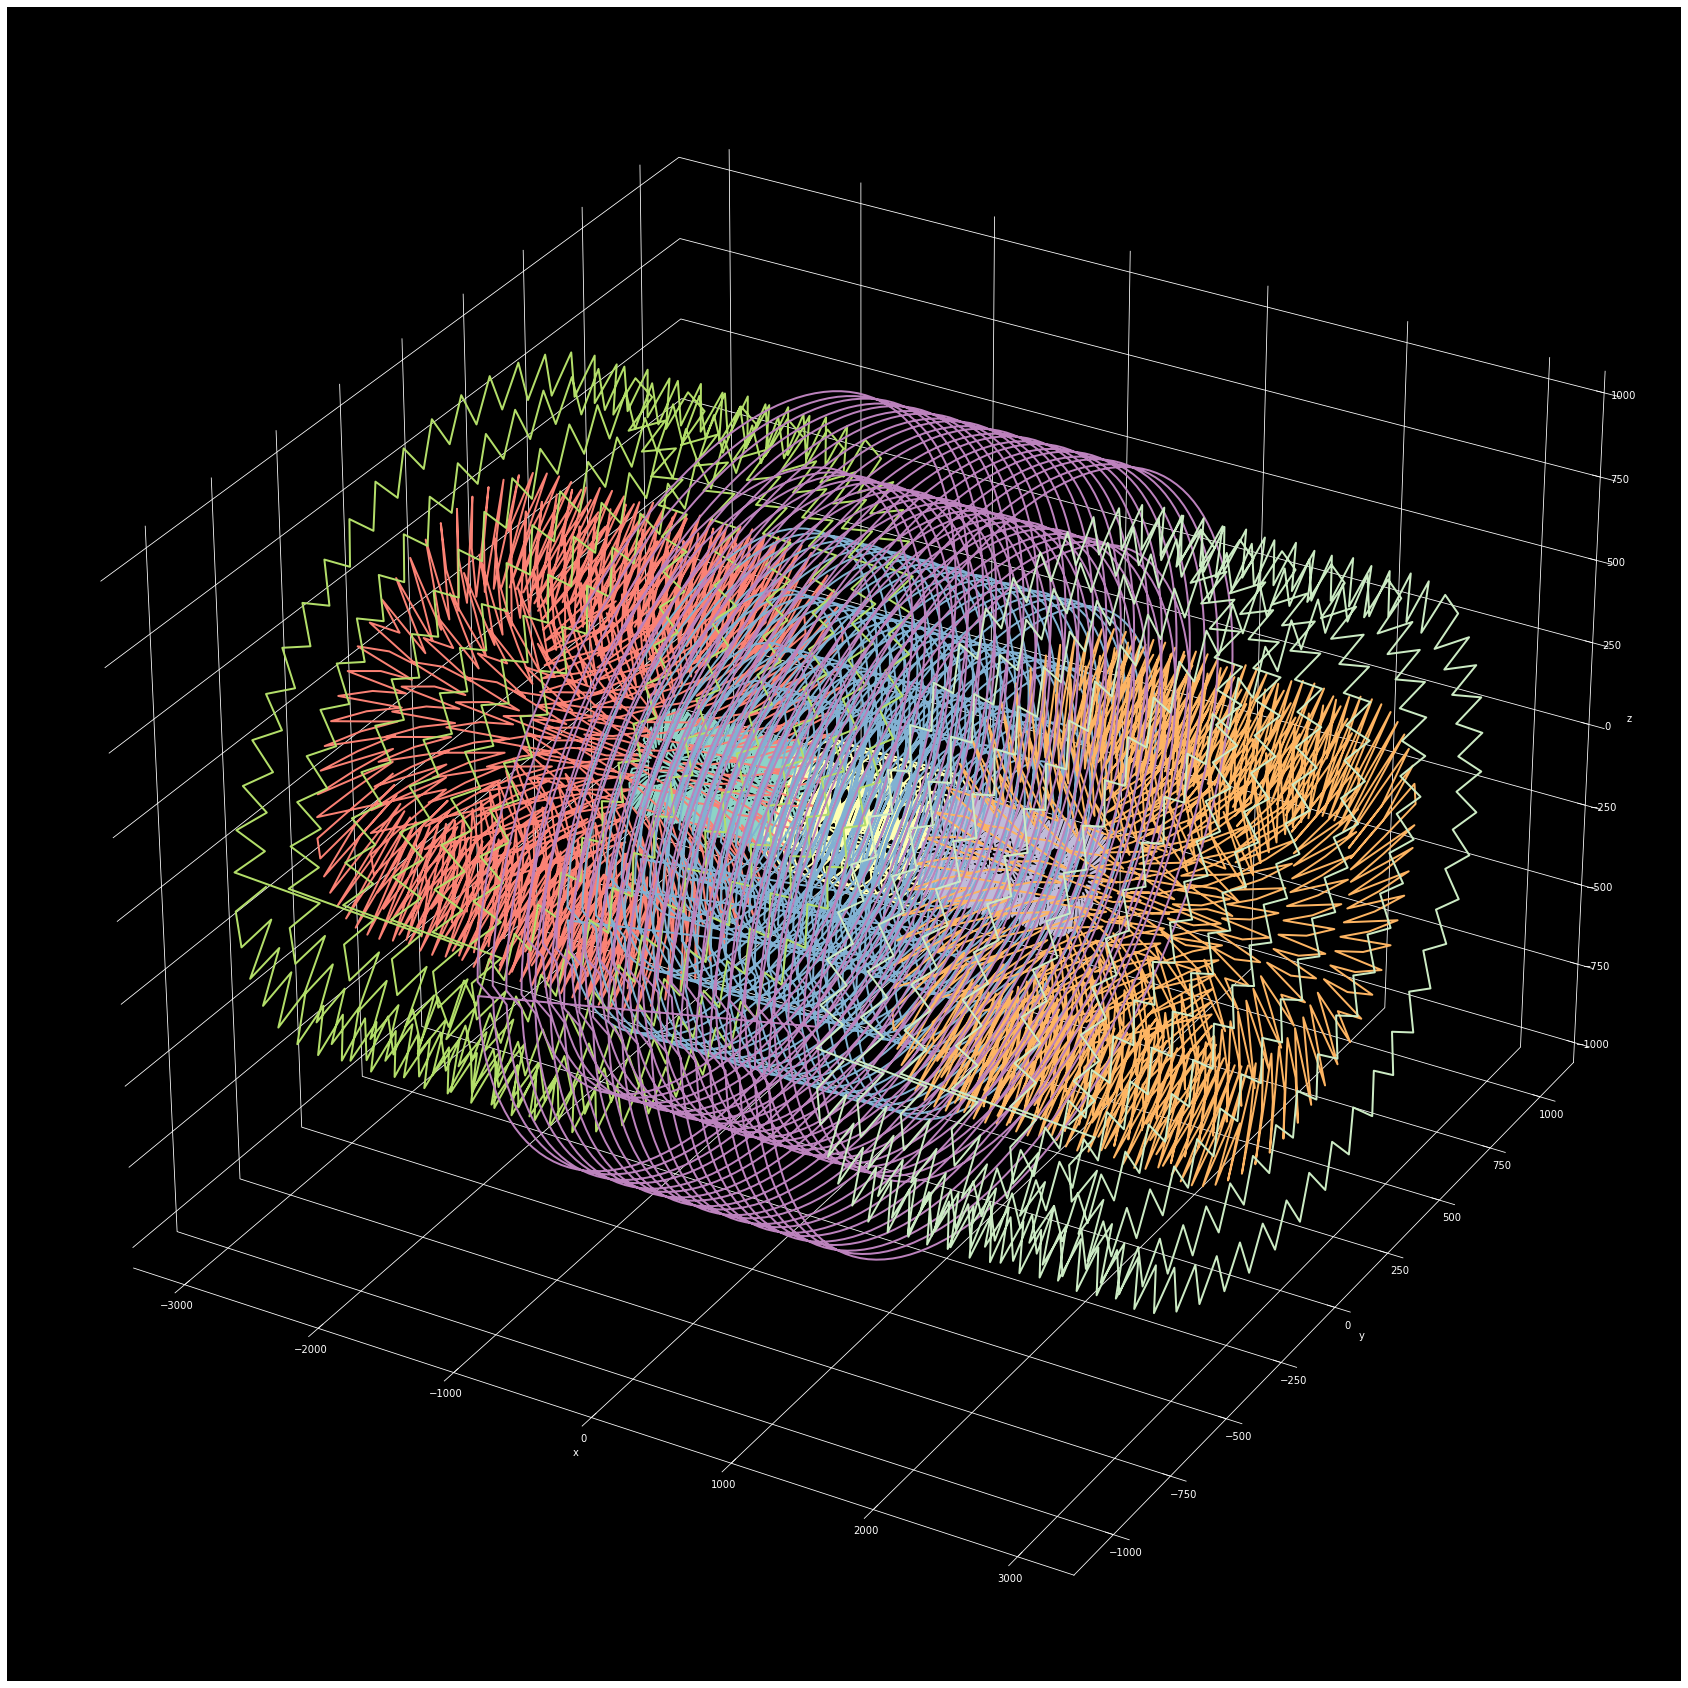

In [8]:

fig = plt.figure(figsize=(30, 24))
fig2 = plt.figure(figsize=(30, 160))

plt.style.use('dark_background')

for k in range(len(groupby)):
    
    ax = fig.add_subplot(6, 8, k+1, projection='3d') # Create 48 3d-subplots with 6 rows and 8 cols
    # Setting Labels, limits and colors of the graf
    ax.set_aspect('auto');
    ax.set_xlabel('x');
    ax.set_ylabel('y');
    ax.set_zlabel('z');
    ax.set_xlim(xmin, xmax);
    ax.set_ylim(ymin, ymax);                        
    ax.set_zlim(zmin, zmax);                        
    ax.xaxis.set_pane_color((1, 1, 1, 0.1));
    ax.yaxis.set_pane_color((1, 1, 1, 0.1));
    ax.zaxis.set_pane_color((1, 1, 1, 0.1));
    
    for (idx, row) in groupby.iloc[:k+1].iterrows():
        xyz = np.array(row['xyz'])
        x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
        ax.plot(x, y, z, linewidth=0.5)

for k in range(len(groupby2)): #Group by volume_id only
    
    ax2 = fig2.add_subplot(projection='3d')
    # Setting Labels, limits and colors of the graf
    ax2.set_aspect('auto')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('z')                   
    ax2.xaxis.set_pane_color((1, 1, 1, 0))
    ax2.yaxis.set_pane_color((1, 1, 1, 0))
    ax2.zaxis.set_pane_color((1, 1, 1, 0))
    
    for (idx, row) in groupby2.iloc[:k+1].iterrows():
        xyz = np.array(row['xyz'])
        x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
        ax2.plot(z, x, y, linewidth=2, visible=True)
        

plt.show()


Some of these layers have smaller number of hits by particles than others. A demostration of a cross section, looking at the different layers.

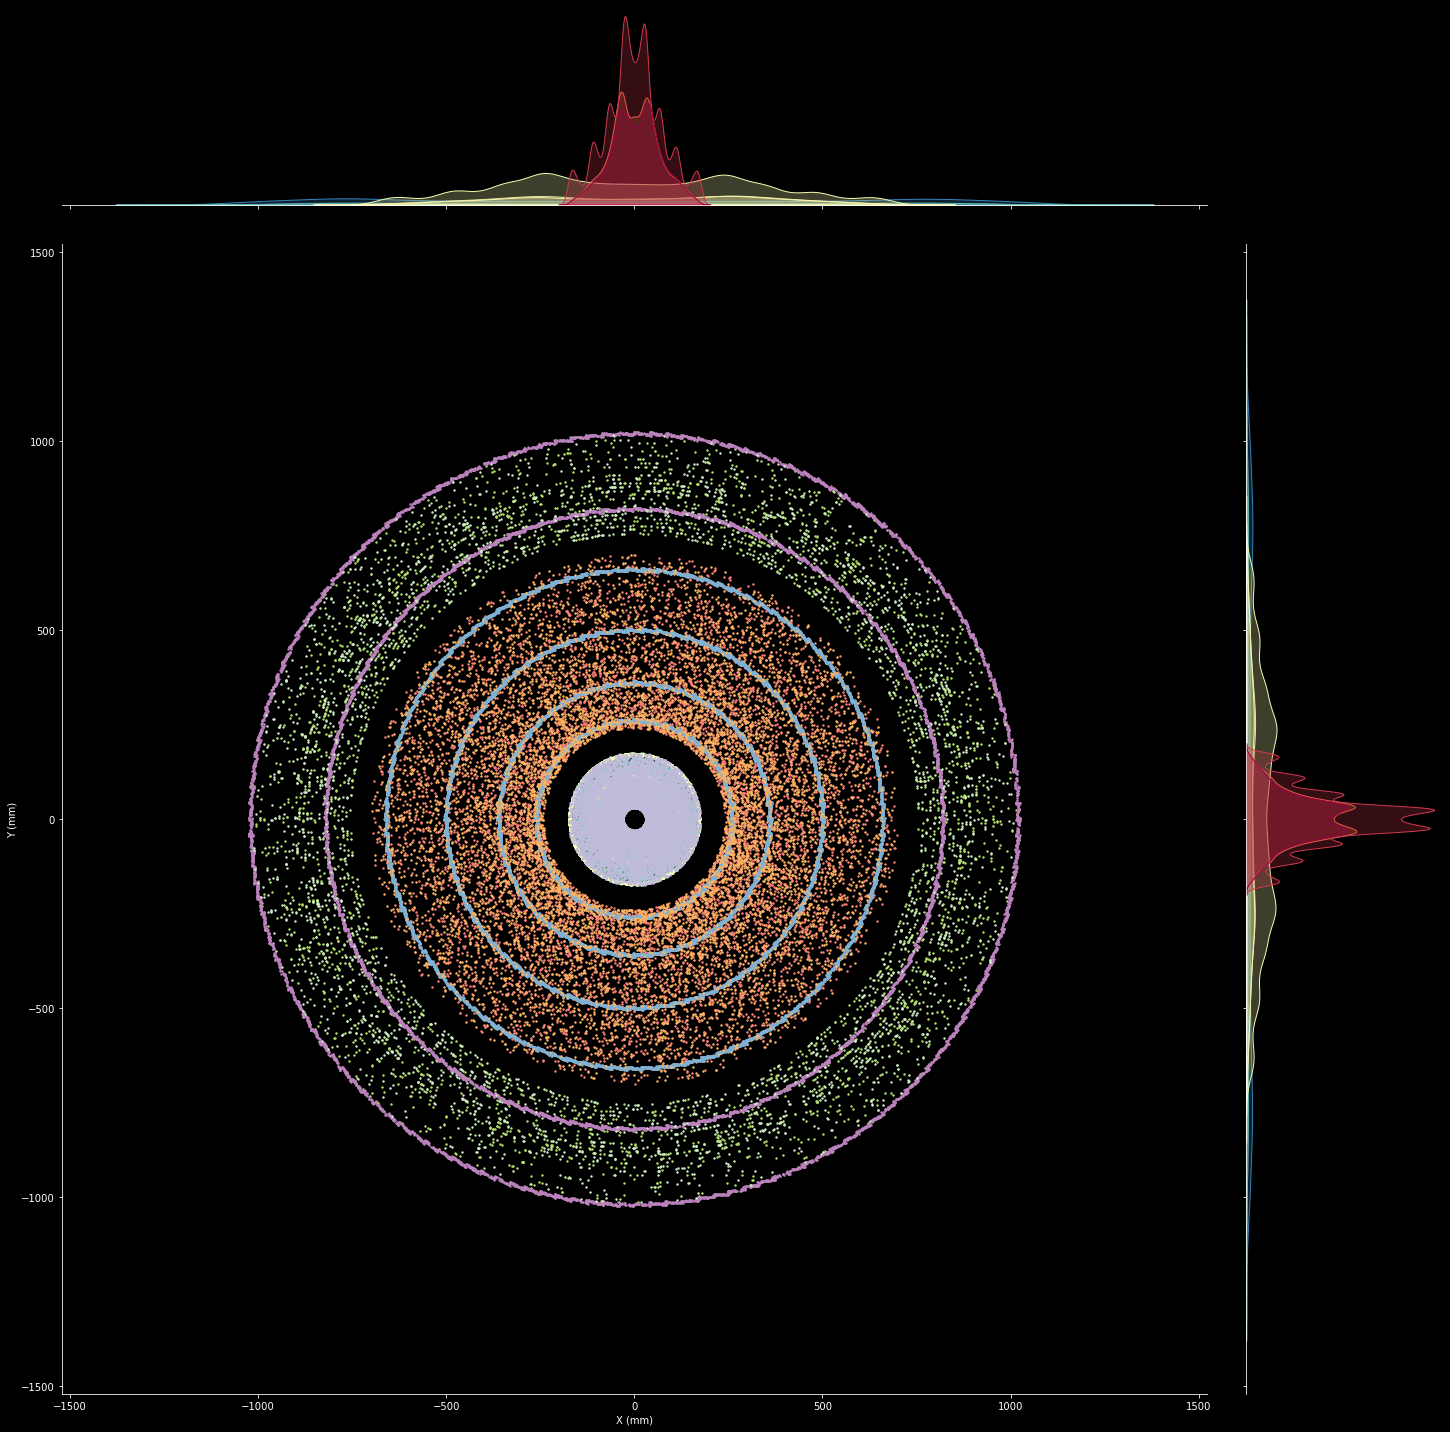

In [9]:
g = sns.jointplot(x='x',y= 'y', data=hits, s=1, height=20, palette='Spectral',hue='volume_id')
g.ax_joint.cla()
plt.sca(g.ax_joint)
 
#A joined plot to show the density of the hits
for vol in groupby2.volume_id:
    v = hits[hits.volume_id == vol]
    x, y= v.x, v.y
    plt.scatter(x, y, s=2)

ax = plt.gca()    
ax.set_xlim(xmin-500, xmax+500);
ax.set_ylim(ymin-500, ymax+500);
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')

plt.show()


<a id='particles'></a>
## Particles

The particle files contains the following values for each particle/entry:

<pre>particle_id: numerical identifier of the particle inside the event.
vx, vy, vz: initial position or vertex (in millimeters) in global coordinates.
px, py, pz: initial momentum (in GeV/c) along each global axis.
q: particle charge (as multiple of the absolute electron charge).
nhits: number of hits generated by this particle.
All entries contain the generated information or ground truth.</pre>


<p>Let's now take a look at the relationship between different Pair combinations of the particle variables.</p>

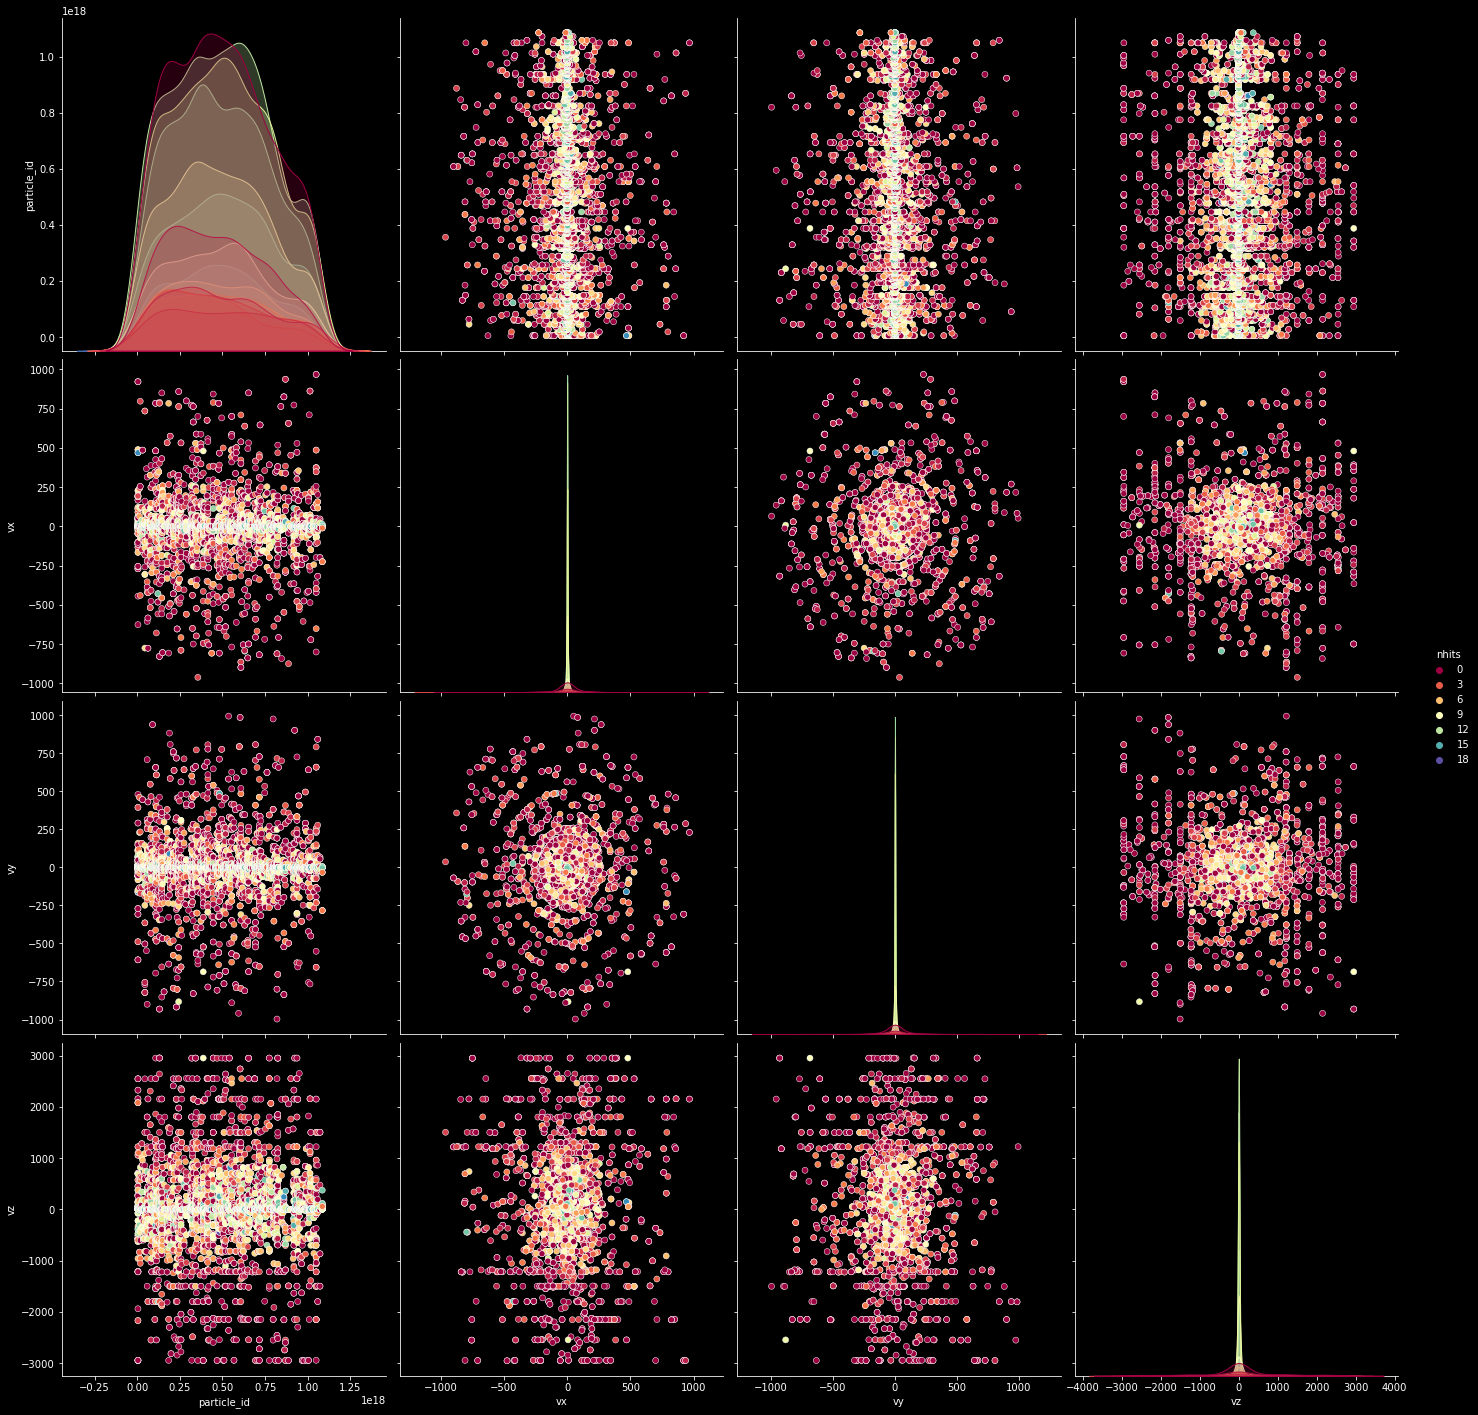

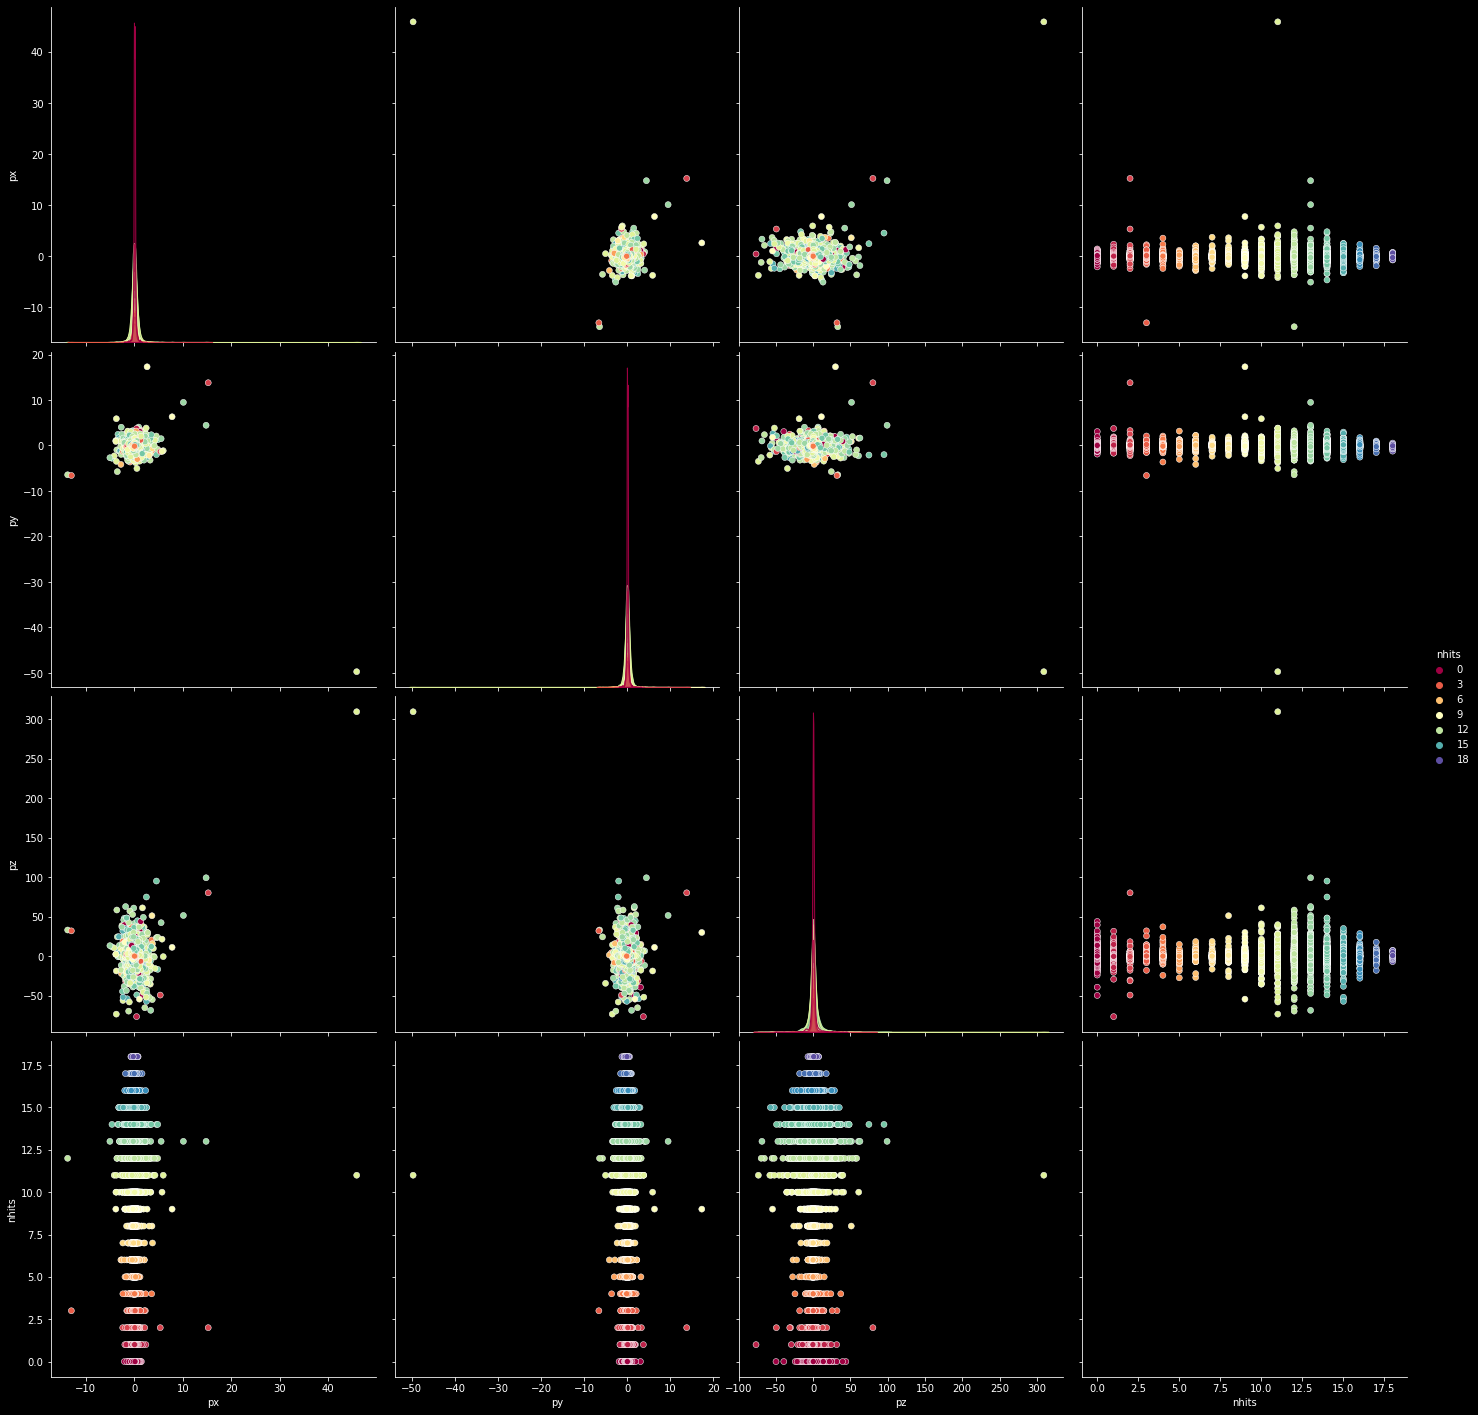

It looks like the particles are targetted towards the global origin  (x,y,z)=(0,0,0)  and are evenly distributed around it.


In [10]:
plt.style.use('dark_background')

p_sample = particles #.sample(10)

sns.pairplot(p_sample, vars=['particle_id', 'vx', 'vy', 'vz'],palette='Spectral', hue='nhits', height=5)
sns.pairplot(p_sample, vars=['px', 'py', 'pz','nhits'],palette='Spectral', hue='nhits', height=5)

plt.show()

print("It looks like the particles are targetted towards the global origin  (x,y,z)=(0,0,0)  and are evenly distributed around it.")


<a id='trajectory'></a>
## Particle trajectories

<pre><b>A bit more details on the events that are going to be used</b></pre>
Event hits
The hits file contains the following values for each hit/entry:

<pre>hit_id: numerical identifier of the hit inside the event.
x, y, z: measured x, y, z position (in millimeter) of the hit in global coordinates.
volume_id: numerical identifier of the detector group.
layer_id: numerical identifier of the detector layer inside the group.
module_id: numerical identifier of the detector module inside the layer.</pre>

Event truth
The truth file contains the mapping between hits and generating particles and the true particle state at each measured hit. Each entry maps one hit to one particle.

<pre>hit_id: numerical identifier of the hit as defined in the hits file.
particle_id: numerical identifier of the generating particle as defined in the particles file. A value of 0 means that the hit did not originate from a reconstructible particle, but e.g. from detector noise.
tx, ty, tz true intersection point in global coordinates (in millimeters) between the particle trajectory and the sensitive surface.
tpx, tpy, tpz true particle momentum (in GeV/c) in the global coordinate system at the intersection point. The corresponding vector is tangent to the particle trajectory at the intersection point.
weight per-hit weight used for the scoring metric; total sum of weights within one event equals to one.</pre>


In [11]:
def particleTrajectories(particleHits, ipvLimit): # This function will manage particle trajectories. It used more than once, so let's make it reusable.
    for i in range(0, len(particleHits)):
        # This will generate particle1, particle2...varibles =  particles.loc[particles.nhits].iloc[0,1...]
        exec("particle%d = particleHits.iloc[%d]" % ((i + 1), i));
        exec("p_traj_surface%d = truth[truth.particle_id == particle%d.particle_id][['tx', 'ty', 'tz']]" % ((i + 1), (i+1)));
        exec("p_traj%d = (p_traj_surface%d.append({'tx': particle%d.vx, 'ty': particle%d.vy, 'tz': particle%d.vz}, ignore_index=True).sort_values(by='tz'))" % ((i + 1), (i + 1), (i + 1), (i + 1), (i + 1)));
        
        if (ipvLimit != 'Null' and ipvLimit != 0) : # to show an ipv graf
            exec("ipv.scatter( x=p_traj%d.tx, y=p_traj%d.ty, z=p_traj%d.tz, color=colors[%d], marker='sphere')" % ((i + 1), (i + 1), (i + 1), i));  
            ipv.xlim(xmin-ipvLimit, xmax+ipvLimit)
            ipv.ylim(ymin-ipvLimit, ymax+ipvLimit)
            ipv.zlim(zmin-ipvLimit, zmax+ipvLimit)
            
        else :  # to show a plot graf
            exec("ax3.plot( xs=p_traj%d.tx, ys=p_traj%d.ty, zs=p_traj%d.tz, marker='o')" % ((i + 1), (i + 1), (i + 1)));

This will be demonstrated only when running .ipynb file. Move it around and have fun.

In [12]:

# Get particle id with max number of hits in this event

ipv.figure(figsize=(30, 160))
ipv.style.use('dark')
iter = len(particles.loc[particles.nhits == particles.nhits.max()]) +1 #to get the exact number of colors, because less will form errors
colors= sns.color_palette('Spectral', iter)
colors= colors.as_hex()

particleTrajectories(particles.loc[particles.nhits == particles.nhits.max()], 1000)
%timeit particleTrajectories(particles.loc[particles.nhits == particles.nhits.max()], 1000)
ipv.show()

175 ms ± 21.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's see it all together


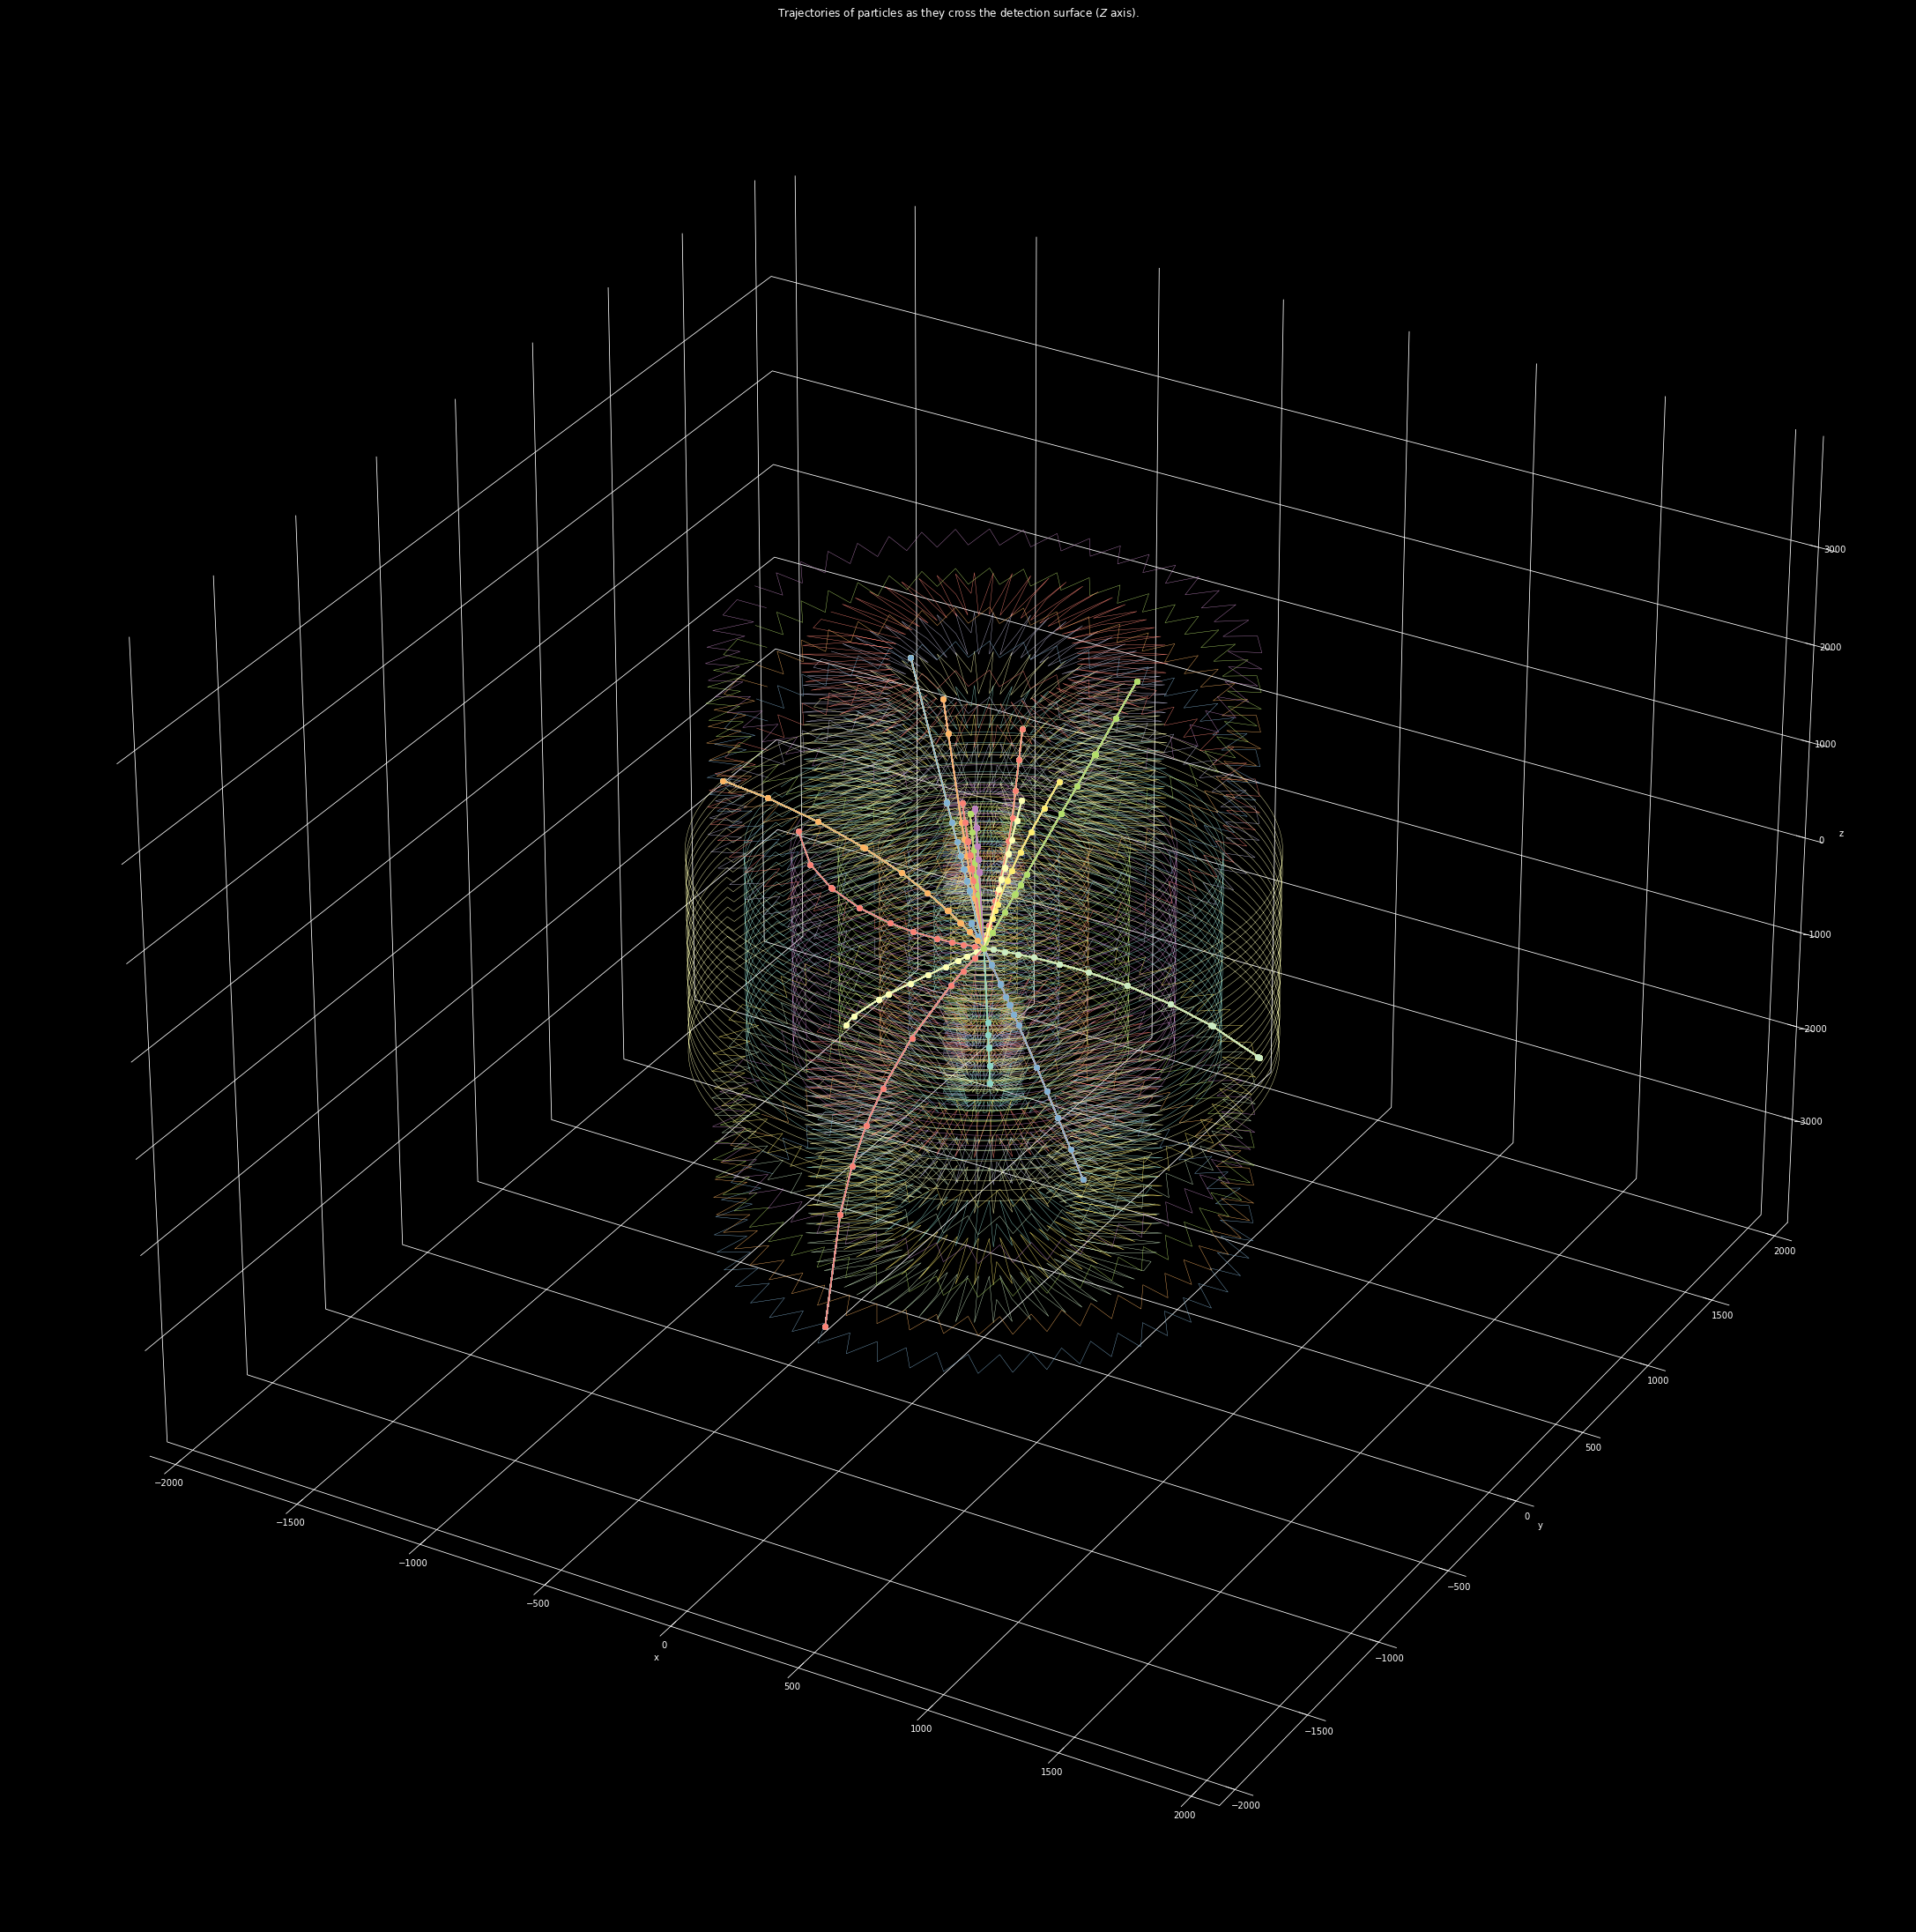

In [13]:
print("Let's see it all together")

#Combined the detector layers and the particle trajectories

fig3 = plt.figure(figsize=(30, 160))

plt.style.use('dark_background')


ax3 = fig3.add_subplot(111, projection='3d')
ax3.set_aspect('auto'); 


for k in range(groupby.shape[0]):
    
    ax3 = fig3.add_subplot(111, projection='3d')
    
    ax3.set_aspect('auto'); 
    ax3.set_xlabel('x'); 
    ax3.set_ylabel('y');    
    ax3.set_zlabel('z');  
    ax3.set_xlim(xmin-1000, xmax+1000);    
    ax3.set_ylim(ymin-1000, ymax+1000);     
    ax3.set_zlim(zmin-1000, zmax+1000);  
    ax3.xaxis.set_pane_color((1, 1, 1, 0))
    ax3.yaxis.set_pane_color((1, 1, 1, 0))
    ax3.zaxis.set_pane_color((1, 1, 1, 0))
     
    for (idx, row) in groupby.iloc[:k+1].iterrows():
        xyz = np.array(row['xyz'])
        x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
        ax3.plot(x, y, z, linewidth=0.4)
        
particleTrajectories(particles.loc[particles.nhits], 0)


plt.tight_layout(pad=0., w_pad=0., h_pad=0.)
plt.title('Trajectories of particles as they cross the detection surface ($Z$ axis).')





plt.show()


<a id='DBSCAN'></a>
## DBSCAN. Why do we need it?

Let's dig a little deeper. The track pattern recognition as clustering problem. Each of the clusters corresponds to one track.

<pre>At first I thought of "Score first and then deal with the running time.", but boy was I wrong. My pc couldn't handle more than 10 min at max and Memory wolud go up to 100%.
So, in conclusion I will go through the steps of using DBSCAN, but with even fewer data.Also will be using score_event from trackml. The result is highly dependent on this. </pre>

<b> DBSCAN (Density-Based Spatial Clustering and Application with Noise)</b>, is a density-based clusering algorithm, introduced in Ester et al. 1996, which can be used to identify clusters of any shape in a data set containing noise and outliers.

To continue with DBSCAN there are 2 important parameters required:

epsilon (eps) : defines the radius of neighborhood around a point x. It’s called called the ϵ-neighborhood of x.
minimum points (MinPts) : the minimum number of neighbors within “eps” radius.

A DBSCAN benchmark kernel uses eps=0.008 and scores 0.2078 on public LB.

With what I have read, it is best for MinPts to be 2*dimensions. With this in mind let's find eps.
Dimensions:  2


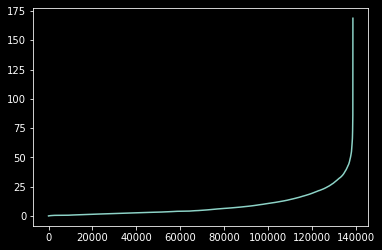

In [14]:
print("With what I have read, it is best for MinPts to be 2*dimensions. With this in mind let's find eps.")
xyzHits = hits.loc[0:, ['x', 'y', 'z']].values

#  NearestNeighbors implements unsupervised nearest neighbors learning. It acts as a uniform interface to three different nearest neighbors algorithms:
#  BallTree, KDTree, and a brute-force algorithm based on routines in sklearn.metrics.pairwise.
print("Dimensions: ", (xyzHits.ndim))

neighbors = NearestNeighbors(n_neighbors=4, algorithm='kd_tree', radius=1.6)
neighbors_fit = neighbors.fit(xyzHits)
distances, indices = neighbors_fit.kneighbors(xyzHits)


distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)




#### The ideal value for ε is be equal to the distance value at the “crook of the elbow”, or the point of maximum curvature. 
This point represents the optimization point where diminishing returns are no longer worth the additional cost. 
This concept of diminishing returns applies here because while increasing the number of clusters will always improve the fit of the model, it also increases the risk that overfitting will occur.
In this case following the graph it seems that the eps is around 35ish

In [15]:
# scale and standardizing data
xyzHits = hits.loc[:, ['x', 'y', 'z']]

xyzHits_train, xyzHits_test = train_test_split(xyzHits, test_size = 0.2)

class DBSCAN_C(object): #This is used by others before me, but I tried my params
    
    def __init__(self, eps): self.eps = eps
        
    
    def _preprocess(self, hits):
        
        x,y,z = hits.x.values, hits.y.values, hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r

        r = np.sqrt(x**2 + y**2)
        hits['z2'] = z/r

        ss = StandardScaler()
        hits2 = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return hits2
    
    
    def predict(self, hits):
        
        predict = self._preprocess(hits)
        
        clust = DBSCAN(eps=self.eps, min_samples=4, algorithm='kd_tree', metric='euclidean')
        labels = clust.fit_predict(predict)
        
        return labels
    
    
model = DBSCAN_C(eps=35) 
labels = model.predict(hits.sample(100))


def one_event_submit(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

submission = one_event_submit(0, hits.sample(100), labels)
score = score_event(truth.sample(100), submission)

print("Final score:", score)
print("If I try more events the score will change again.")

%timeit score_event(truth.sample(100), submission)


Final score: 0.987049460231129
If I try more events the score will change again.
7.72 ms ± 72.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
